# QUANTUM BASTA
During the past years, it has spread the necessity of studying simple quantum systems so as to comprehend how more difficult quantum system behave and evolve. Many approaches has been used, whereas the Agassi's one has been considered very little.

QUANTUM BASTA project is based on the study of the Agassi Model, a nuclear physics approach aimed at the comprehension of the atomic nucleus behaviour. This quantum model is a combination of long range monopole-monopole and short range pairing interactions of N fermions.

The fermions are split into two different levels, each of degeneracy $\Omega$ (which is an even value). Using $\Omega$ we can define $j=\Omega /2$ which will be the parameter that indicates the particles' number considered in the simulation. 
Narrowing it down to the case where $N=2\Omega$, we obtain the relation $N=4*j$ . Another thing that is need to be said is that the two energy levels are identified by a different parity value, σ = -1 and σ = 1, while the magnetic quantum number takes the values m = ±1,...,± j (m = 0 is excluded). Thus, a single-particle state is labelled by (σ = ±,m).

For the work we relied on an article pubblicated on Physical Review B, titled "A digital quantum simulation of the Agassi model" by Pedro Pérez-Fernández (inserire link al paper). The first step consisted in duplicating the paper's results; then we proceeded with improving the code in order to get more reliability and efficiency. 

### Introduction

In [1]:
import pennylane as qml
from itertools import combinations
import networkx as nx
import numpy as np

from scipy.linalg import expm
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq


In [2]:
print(qml.__version__)

0.40.0


### Global variables

In this very first part, all the parameters and variables used are enlisted. $j$,$ \epsilon$,$g$ and $V$ are parameters that define the hamiltonian, and so, the simulation. The others are parameters used within function and loops; each of them is appropriately commented.

In [3]:
j=2
eps=1.0
g=0.3
V=0.3

v = 15#12 #initial state
n_qubits = 4*j

In [4]:
# Parameters for time evolution

t_max = 10.0           # Maximum evolution time
time_steps = 150        # Number of time intervals

# Define the time intervals
times = np.linspace(0, t_max, time_steps)

## Encoding Method

The starting point is the hamiltonian which is

$H = \epsilon J^{0} - g \sum_{\sigma = -1,1} A_{\sigma}^{\dagger} A_{\sigma} - \frac{V}{2} \left( J^+ J^- + J^- J^+ \right).$ 

For a better comprehension of the terms we refer to the article. Nevertheless, it is crucial to be said that the expression is not usable for digital simulation. It is needed a mapping into another form of the hamiltonian, the one obtained through the Jordan-Wigner trasformation. The ENCODING METHOD paragraph contains all the commands that map operators denoted by two indexes into operators named by only one index, whereas HAMILTONIAN applies the J-W trasformation.


In [5]:
def encode_indices(p, m, j):
    """
    takes two different p, m and j and  encode indexes with the specified rule, it can be used for every value of j 
    """
    if p not in {1, -1}:
        raise ValueError("p must be either 1 or -1.")
    if m == 0 or not (-j <= m <= j):
        raise ValueError(f"m must be in the range +/-1, +/-2, ..., +/-j, but got m={m} and j={j}.")

    if m > 0:
        k = j - m
    else:
        k = j - m - 1 # shift by one because m can't be 0

    if p == -1:
        k += 2 * j

    return k

def decode_index(k, j):
    """
    Decode a single index k back into multi-indexes (p, m, j)
    """
    if k < 0 or k >= 4 * j:
        raise ValueError(f"k={k} is out of valid range for j={j}.")

    # Determine p based on the range of k
    p = 1 if k < 2 * j else -1

    # Adjust k for p = -1
    k_adjusted = k if p == 1 else k - 2 * j

    # Determine m
    m = j - k_adjusted if k_adjusted < j else j - (k_adjusted + 1) # inverse of the encoding line in encode_indices

    return p, m

"`encode_indices`" has the task to encode the creation and annihilator operators mapping the couple parity-magnetic quantum number $(p,m)$ into a sigle index. The variable $k$ is computated using $p,m,j$ and returns exactly the new index for the operator. As every part of the code, this paragraph is thinked for generalization of j. 

The second function is the inverse process, it helps getting back the couple $(p,m)$ using only the singular operator index. It is important to check the values ​​assumed by the parameters, which is done at the beginning of the functions.

### Test Encoding

This part has the only purpose to demonstrate how the previous functions work.

In [6]:

for p in [1, -1]:
    for m in range(j, -j-1, -1):
        if m == 0: continue

        k = encode_indices(p, m, j)
        p_, m_ = decode_index(k, j)

        print("Original indices: p={}, m={}".format(p, m, j))
        print("Decoded indices:  p={}, m={}".format(p_, m_))
        print("Encoded index:    k={}".format(k))
        print()

Original indices: p=1, m=2
Decoded indices:  p=1, m=2
Encoded index:    k=0

Original indices: p=1, m=1
Decoded indices:  p=1, m=1
Encoded index:    k=1

Original indices: p=1, m=-1
Decoded indices:  p=1, m=-1
Encoded index:    k=2

Original indices: p=1, m=-2
Decoded indices:  p=1, m=-2
Encoded index:    k=3

Original indices: p=-1, m=2
Decoded indices:  p=-1, m=2
Encoded index:    k=4

Original indices: p=-1, m=1
Decoded indices:  p=-1, m=1
Encoded index:    k=5

Original indices: p=-1, m=-1
Decoded indices:  p=-1, m=-1
Encoded index:    k=6

Original indices: p=-1, m=-2
Decoded indices:  p=-1, m=-2
Encoded index:    k=7



## Hamiltonian

In [7]:
# Annihilation operator
def C(p, m, j):
    return qml.FermiA(encode_indices(p, m, j))

# Creation operator
def C_dag(p, m, j):
    return qml.FermiC(encode_indices(p, m, j))

# Agassi Hamiltonian
def agassi_hamiltonian(j, eps, g, V):
    """
    Compute the hamiltonian expression in creation and annihilation operators, evaluating each terms of the Agassi hamiltonian.
    Every term use the mapping into single index 
    """
    # J0 term
    J0 = 0
    for m in range(j, -j-1, -1):
        if m == 0: continue
        J0 += C_dag(1, m, j) * C(1, m, j) - C_dag(-1, m, j) * C(-1, m, j)
    J0 *= 0.5

    # J+ and J- term
    J_plus = 0
    J_minus = 0
    for m in range(j, -j-1, -1):
        if m == 0: continue
        J_plus  += C_dag(1, m, j) * C(-1, m, j)
        J_minus += C_dag(-1, m, j) * C(1, m, j)

    # A_i terms

    def A_dag(p, j):
        res = 0
        """ 
        unlike the previous loops here we go from m=0 to m=j-1 (m=1 to m=j in the paper)
        """
        for m in range(0, j+1):
            if m == 0: continue
            res += C_dag(p, m, j) * C_dag(p, -m, j)
        return res

    def A(p, j):
        res = 0
        """
        unlike the previous loops here we go from m=0 to m=j-1 (m=1 to m=j in the paper)
        """
        for m in range(0, j+1):
            if m == 0: continue
            res += C(p, -m, j) * C(p, m, j)
        return res

    A_terms = 0
    for p in [-1, 1]:
        for p_ in [-1, 1]:
            A_terms += A_dag(p, j) * A(p_, j)


    # Hamiltonian
    H = eps * J0 - g * A_terms - V/2 * (J_plus * J_plus + J_minus * J_minus)

    return H

H_sec = agassi_hamiltonian(j, eps, g, V)
print("Second quantization Hamiltonian:")
print(H_sec)
print()

H_ps = qml.jordan_wigner(H_sec, ps=True, wire_map=None)
"""
exploiting the jordan-wigner transformation
"""
# H = H.simplify()
print("Jordan-Wigner Hamiltonian:")
print(H_ps)
print()


Second quantization Hamiltonian:
-0.15 * a⁺(0) a(4) a⁺(0) a(4)
+ -0.0 * a⁺(0) a(4)
+ -0.15 * a⁺(0) a(4) a⁺(1) a(5)
+ -0.15 * a⁺(0) a(4) a⁺(2) a(6)
+ -0.15 * a⁺(0) a(4) a⁺(3) a(7)
+ 0.0 * I
+ -0.0 * a⁺(1) a(5)
+ -0.0 * a⁺(2) a(6)
+ -0.0 * a⁺(3) a(7)
+ -0.15 * a⁺(1) a(5) a⁺(0) a(4)
+ -0.15 * a⁺(1) a(5) a⁺(1) a(5)
+ -0.15 * a⁺(1) a(5) a⁺(2) a(6)
+ -0.15 * a⁺(1) a(5) a⁺(3) a(7)
+ -0.15 * a⁺(2) a(6) a⁺(0) a(4)
+ -0.15 * a⁺(2) a(6) a⁺(1) a(5)
+ -0.15 * a⁺(2) a(6) a⁺(2) a(6)
+ -0.15 * a⁺(2) a(6) a⁺(3) a(7)
+ -0.15 * a⁺(3) a(7) a⁺(0) a(4)
+ -0.15 * a⁺(3) a(7) a⁺(1) a(5)
+ -0.15 * a⁺(3) a(7) a⁺(2) a(6)
+ -0.15 * a⁺(3) a(7) a⁺(3) a(7)
+ -0.15 * a⁺(4) a(0) a⁺(4) a(0)
+ -0.0 * a⁺(4) a(0)
+ -0.15 * a⁺(4) a(0) a⁺(5) a(1)
+ -0.15 * a⁺(4) a(0) a⁺(6) a(2)
+ -0.15 * a⁺(4) a(0) a⁺(7) a(3)
+ -0.0 * a⁺(5) a(1)
+ -0.0 * a⁺(6) a(2)
+ -0.0 * a⁺(7) a(3)
+ -0.15 * a⁺(5) a(1) a⁺(4) a(0)
+ -0.15 * a⁺(5) a(1) a⁺(5) a(1)
+ -0.15 * a⁺(5) a(1) a⁺(6) a(2)
+ -0.15 * a⁺(5) a(1) a⁺(7) a(3)
+ -0.15 * a⁺(6) a(2) a⁺(4) a(0)

#### Add Implicit Terms to Hamiltonian
If Pennylane finds pauli sentences that contain null coefficients related to some pauli words, it erases automatically those terms. This can create some problems if we want to compute calculation between expressions that have different dimensions, because the code doesn't recognise the missing parts. That's why we introduce manually all the terms previously removed from the hamiltonian, exploiting `add_implicit_terms`.

In [8]:
from copy import deepcopy

def add_implicit_terms(H1_raw, n_qubits):
    """
    a copy of the hamiltonian given as an input is made, then it is done a check of the pauli words contained within the hamiltonian expression
    and if some specific pauli words have been removed by Pennlyane they're reintroduced pinned to a coefficient equals to 0.0.
    """
    H_new = deepcopy(H1_raw)
    for i in range(0, n_qubits):
        w = qml.pauli.PauliWord({i:"Z"})
        if w not in H1_raw:
            H_new[w] = 0.0
    return H_new

## Time Evolution functions

### create initial state
In the following part, it is inserted inside the code the initial state that is going to be evolved with different methods, such as exact evolution or trotterization. The state is defined as an array with all zeros except for an element set to 1 at the position v, previously introduced.

In [9]:

# Initial state

dim = 2**n_qubits
initial_state = np.zeros(dim, dtype=complex)
initial_state[v] = 1.0

print(initial_state.shape)
print(n_qubits)

(256,)
8


### Get matrix form of hamiltonian terms
These commands have the purpose to translate hamiltonian into matrix, usable in quantum systems and simulations. Once it is determined the order of quantum bits, the hamiltonian is turned into its matrix form using `qml.matrix`, following the order just defined. Through `add_implicit_terms` we complete the expression introducing the operators that were eliminated by Pennylane. Then, we extrapolate the matrix form.

In [10]:
#get matrix form of all the hamiltonians

order = list(range(n_qubits))

for i in range(0,n_qubits):
    order[i]=i

H = qml.matrix(add_implicit_terms(H_ps, n_qubits), wire_order=order)
"""this function give the matrix form of the hamiltonian"""
# H = get_matrix_from_ps(H_ps)




'this function give the matrix form of the hamiltonian'

In [11]:

def exact_evo(t):
    U = np.identity(H.shape[0])
    U = U @ expm(-1j * H * (t))
    evolved_state = U @ initial_state
    return evolved_state


`correlation_function` is the commands' block whose purpose is to evaluate the correlation function, which is $\sigma_z(1,2) \equiv \braket{\sigma_z^1 \sigma_z^2} - \braket{\sigma_z^1} \braket{\sigma_z^2}$. It uses the evolution of the state done with Trotter process to calculate the expectation value. 

In [12]:
#compute correlation function
def correlation_function(evo):
    i=1
    k=3
    """calculation of the correlation function for Z-Pauli operators"""
    Zi_raw = qml.pauli.PauliWord({i:"Z"})
    Zk_raw = qml.pauli.PauliWord({k:"Z"})
    psi = qml.pauli.PauliSentence()
    psi[Zi_raw]= 1.0
    psk = qml.pauli.PauliSentence()
    psk[Zk_raw]= 1.0

    order = list(range(n_qubits))
    for s in range(0,n_qubits):
        order[s]=s

    Zi=qml.matrix(add_implicit_terms(psi, n_qubits), wire_order=order)
    Zk=qml.matrix(add_implicit_terms(psk, n_qubits), wire_order=order)

    sigma_ik=np.vdot(evo ,Zi @ evo)*np.vdot(evo,Zk @ evo)#np.vdot(evo, Zi @ Zk @ evo)-np.vdot(evo ,Zi @ evo)*np.vdot(evo,Zk @ evo)

    return sigma_ik

In [13]:
def correlation_function_free_parameters(i,k,evo):
    """calculation of the correlation function for Z-Pauli operators"""
    Zi_raw = qml.pauli.PauliWord({i:"Z"})
    Zk_raw = qml.pauli.PauliWord({k:"Z"})
    psi = qml.pauli.PauliSentence()
    psi[Zi_raw]= 1.0
    psk = qml.pauli.PauliSentence()
    psk[Zk_raw]= 1.0

    order = list(range(n_qubits))
    for s in range(0,n_qubits):
        order[s]=s



    Zi=qml.matrix(add_implicit_terms(psi, n_qubits), wire_order=order)
    Zk=qml.matrix(add_implicit_terms(psk, n_qubits), wire_order=order)

    sigma_ik=np.vdot(evo, Zi @ Zk @ evo)-np.vdot(evo ,Zi @ evo)*np.vdot(evo,Zk @ evo)

    return sigma_ik

In [14]:
def correlation_function_free_parameters1(i,k,evo):
    """calculation of the correlation function for Z-Pauli operators"""
    Zi_raw = qml.pauli.PauliWord({i:"Z"})
    Zk_raw = qml.pauli.PauliWord({k:"Z"})
    psi = qml.pauli.PauliSentence()
    psi[Zi_raw]= 1.0
    psk = qml.pauli.PauliSentence()
    psk[Zk_raw]= 1.0

    order = list(range(n_qubits))
    for s in range(0,n_qubits):
        order[s]=s



    Zi=qml.matrix(add_implicit_terms(psi, n_qubits), wire_order=order)
    Zk=qml.matrix(add_implicit_terms(psk, n_qubits), wire_order=order)

    sigma_ik=np.vdot(evo, Zi @ Zk @ evo)

    return sigma_ik

### Exact Evolution

In [15]:

overlaps_exact_evo = []
correlations_exact = []
states_exact_evo = []
i=0
# Compute the overlap with initial state
for t in times:
    result = exact_evo(t)
    states_exact_evo.append(result)
    #result = result.numpy()  # Convert to NumPy array if required

    overlap = np.vdot(initial_state, result)
    overlap = np.abs(overlap)**2
    overlaps_exact_evo.append(overlap)

    correlation_exact = correlation_function(result)
    correlations_exact.append(correlation_exact)
    
    i=i+1
    print(i, "/", len(times))


1 / 150
2 / 150
3 / 150
4 / 150
5 / 150
6 / 150
7 / 150
8 / 150
9 / 150
10 / 150
11 / 150
12 / 150
13 / 150
14 / 150
15 / 150
16 / 150
17 / 150
18 / 150
19 / 150
20 / 150
21 / 150
22 / 150
23 / 150
24 / 150
25 / 150
26 / 150
27 / 150
28 / 150
29 / 150
30 / 150
31 / 150
32 / 150
33 / 150
34 / 150
35 / 150
36 / 150
37 / 150
38 / 150
39 / 150
40 / 150
41 / 150
42 / 150
43 / 150
44 / 150
45 / 150
46 / 150
47 / 150
48 / 150
49 / 150
50 / 150
51 / 150
52 / 150
53 / 150
54 / 150
55 / 150
56 / 150
57 / 150
58 / 150
59 / 150
60 / 150
61 / 150
62 / 150
63 / 150
64 / 150
65 / 150
66 / 150
67 / 150
68 / 150
69 / 150
70 / 150
71 / 150
72 / 150
73 / 150
74 / 150
75 / 150
76 / 150
77 / 150
78 / 150
79 / 150
80 / 150
81 / 150
82 / 150
83 / 150
84 / 150
85 / 150
86 / 150
87 / 150
88 / 150
89 / 150
90 / 150
91 / 150
92 / 150
93 / 150
94 / 150
95 / 150
96 / 150
97 / 150
98 / 150
99 / 150
100 / 150
101 / 150
102 / 150
103 / 150
104 / 150
105 / 150
106 / 150
107 / 150
108 / 150
109 / 150
110 / 150
111 / 15

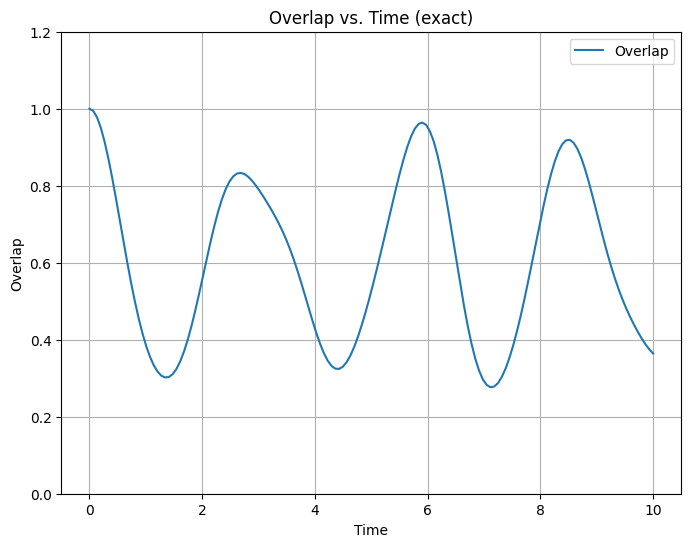

In [16]:

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(times, overlaps_exact_evo, label="Overlap")
plt.xlabel("Time")
plt.ylabel("Overlap")
plt.ylim([0, 1.2])
plt.title("Overlap vs. Time (exact)")
plt.grid()
plt.legend()
plt.show()



### Error

/Users/massimodicosimo/miniconda3/envs/qctrieste24/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/massimodicosimo/miniconda3/envs/qctrieste24/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


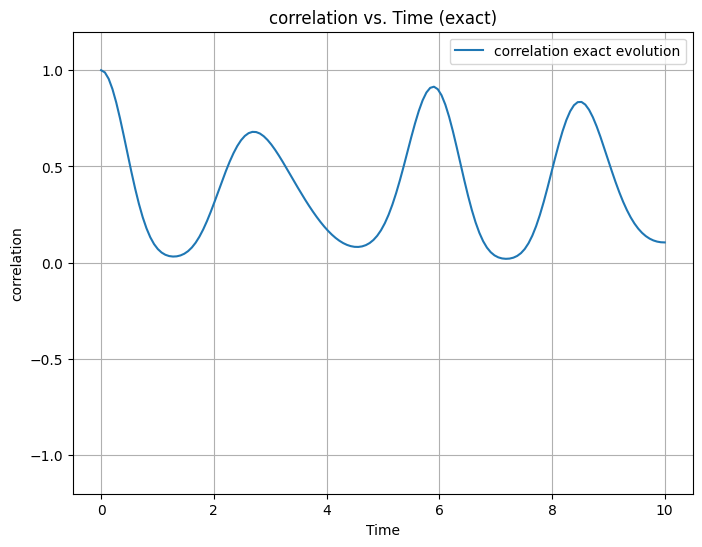

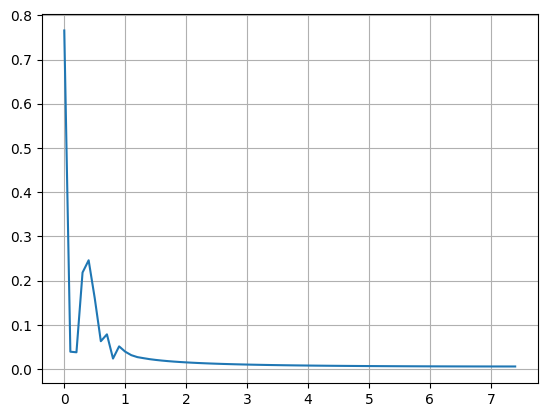

In [17]:
# Plot correlations

plt.figure(figsize=(8, 6))
plt.plot(times, correlations_exact, label="correlation exact evolution")

plt.xlabel("Time")
plt.ylabel("correlation")
plt.ylim([-1.2, 1.2])
plt.title("correlation vs. Time (exact)")
plt.grid()
plt.legend()
plt.show()


yf = fft(correlations_exact)
xf = fftfreq(time_steps, t_max/time_steps)[:time_steps//2]
import matplotlib.pyplot as plt
plt.plot(xf, 2.0/time_steps * np.abs(yf[0:time_steps//2]))
plt.grid()
plt.show()



In [18]:


# dev = qml.device("default.qubit", wires=int(np.log2(H.shape[0])))
# @qml.qnode(dev)

# def pennylane_evo(t, n, v):
#     b=int(np.log2(H.shape[0]))
#     for i in range (0, b):
#         if v >= (2**(b-i-1)):
#             qml.PauliX(wires=(i))
#             v=v-2**(b-i-1)
#         # print(v)
#     qml.ApproxTimeEvolution(H_ps.hamiltonian(), t, n)
#     return qml.state()


### Check which initial states evolve
`get_initial_state` returns the state associated to the input. The latter indicates unambiguously the computation base vector, defined by all zeros excepts for the value at the position v-th, which has to be 1. 

In [19]:
# #checks for every inital state which one evolves
# dim = 2**n_qubits
# def get_initial_state(v):
#     initial_state = np.zeros(dim, dtype=complex)
#     initial_state[v] = 1
#     return initial_state

# print(initial_state.shape)

# def exact_evo_all(t, v, H):
#     initial_state=get_initial_state(v)
#     U = np.identity(H.shape[0])
#     U = U @ expm(-1j * H * (t))
#     evolved_state = U @ initial_state
#     overlap=np.abs(np.vdot(evolved_state, initial_state))**2
#     return overlap

# for v in range(0,2**n_qubits):
#     print(v, exact_evo_all(5, v, H))

In [20]:
correlations_between_qubits = []
for i in range(0, n_qubits):
    for k in range(0, n_qubits):
        evo=exact_evo(2)
        corr=correlation_function_free_parameters(i, k, evo)
        corr1=correlation_function_free_parameters1(i, k, evo)
        print(i,k,corr, corr1)

0 0 (0.693736447432069+0j) (0.9999999999999998+0j)
0 1 (-0.18959391942409737+0j) (0.11666963314383333+0j)
0 2 (-0.18959391942409745+0j) (0.11666963314383325+0j)
0 3 (0.6937176484484138+0j) (0.9999812010163447+0j)
0 4 (-0.25064361763118326+0j) (-0.5569071701991141+0j)
0 5 (-0.2534989103767881+0j) (-0.5597624629447189+0j)
0 6 (-0.25349891037678807+0j) (-0.5597624629447189+0j)
0 7 (-0.2506248186475284+0j) (-0.5568883712154591+0j)
1 0 (-0.18959391942409737+0j) (0.11666963314383333+0j)
1 1 (0.6937364474320692+0j) (0.9999999999999998+0j)
1 2 (0.6937176484484141+0j) (0.9999812010163447+0j)
1 3 (-0.1895939194240975+0j) (0.11666963314383325+0j)
1 4 (-0.2534989103767882+0j) (-0.5597624629447189+0j)
1 5 (-0.2506436176311834+0j) (-0.5569071701991141+0j)
1 6 (-0.2506248186475284+0j) (-0.5568883712154591+0j)
1 7 (-0.2534989103767883+0j) (-0.5597624629447189+0j)
2 0 (-0.18959391942409745+0j) (0.11666963314383325+0j)
2 1 (0.6937176484484141+0j) (0.9999812010163447+0j)
2 2 (0.6937364474320692+0j) (0.99

## Clustering

In [21]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn_extra.cluster import KMedoids


In [22]:
H=0

In [23]:
# exact time evolution
def exact_evo_new(H, t):
    U = np.identity(H.shape[0])
    U = U @ expm(-1j * H * (t))
    evolved_state = U @ initial_state
    return evolved_state

def get_ham_matrix_form(j, eps, g, V):
    H_sec = agassi_hamiltonian(j, eps, g, V)
    H_ps = qml.jordan_wigner(H_sec, ps=True)
    order = list(range(n_qubits))
    for i in range(0,n_qubits):
        order[i]=i
    H = qml.matrix(H_ps, wire_order=order)
    return H

def get_correlations_from_ham(H, times, evo_func=exact_evo_new):
    correlations = []
    for t in times:
        result = evo_func(H, t)
        correlation = correlation_function(result)
        correlations.append(correlation)
    return correlations

def get_g_V_from_sigma_xi(sigma, xi, eps, j):
    g = sigma * eps /  (2*j-1)
    V = xi * eps /  (2*j-1)
    return g, V

# get correlations from parameter lists
def get_correlations_from_param_list(times, g_list, V_list, verbose=False):
    correlations_list = []
    fftss=[]
    i = 0
    n_tot = len(g_list) * len(V_list)
    for g in g_list:
        for V in V_list:
            H = get_ham_matrix_form(j, eps, g, V)
            correlations = get_correlations_from_ham(H, times)

            # do fourier transform of correlations if wanted (uncomment otherwise)
            # correlations = np.fft.fft(correlations)
            # correlations = np.abs(correlations)

            # maxx=[]
            # yf = fft(correlations)
            # xf = fftfreq(len(times), t_max/len(times))
            # for l in range(0, 10):
            #     m = np.argmax(np.abs(np.real(np.array(yf))))
            #     max_freq = xf[m]
            #     maxx.append(max_freq)
            #     yf[m] = 0
            
            # maxx = np.array(maxx)
            # print(yf.shape)
            yf=fft(correlations)
            fftss.append(yf)
            correlations_list.append(correlations)
            
            i += 1
            if verbose:
                if i % 10 == 0:
                    print(f"Progress: {i}/{n_tot}")
                # print(j, eps, g, V, len(correlations))
    return correlations_list, fftss


In [24]:
sigma_list = np.linspace(0.4, 1.6, 20)
xi_list = np.linspace(0.4, 1.6, 20)
times = np.linspace(0, t_max, 75)



g_list, V_list = get_g_V_from_sigma_xi(sigma_list, xi_list, eps, j)



In [25]:

correlations_list, fuorier = get_correlations_from_param_list(times, g_list, V_list, verbose=True)
correlations_list = np.real(np.array(correlations_list))





Progress: 10/400
Progress: 20/400
Progress: 30/400
Progress: 40/400
Progress: 50/400
Progress: 60/400
Progress: 70/400
Progress: 80/400
Progress: 90/400
Progress: 100/400
Progress: 110/400
Progress: 120/400
Progress: 130/400
Progress: 140/400
Progress: 150/400
Progress: 160/400
Progress: 170/400
Progress: 180/400
Progress: 190/400
Progress: 200/400
Progress: 210/400
Progress: 220/400
Progress: 230/400
Progress: 240/400
Progress: 250/400
Progress: 260/400
Progress: 270/400
Progress: 280/400
Progress: 290/400
Progress: 300/400
Progress: 310/400
Progress: 320/400
Progress: 330/400
Progress: 340/400
Progress: 350/400
Progress: 360/400
Progress: 370/400
Progress: 380/400
Progress: 390/400
Progress: 400/400


In [26]:
print(yf.shape)
fuorier = np.real(np.array(fuorier))

(150,)


In [27]:
correlations_list.shape

(400, 75)

In [28]:
kmeans = KMeans(n_clusters=3, random_state=8405)
#kmeans=KMedoids(n_clusters=2, metric='manhattan', random_state=2435)
#means = DBSCAN(eps=0.3, min_samples=1)
#correlations_list = StandardScaler().fit_transform(correlations_list)
kmeans.fit(correlations_list)

KMeans(n_clusters=3, random_state=8405)

In [29]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

print("Cluster Centers:\n", centroids)
print("Assigned Labels:\n", labels)

Cluster Centers:
 [[1.         0.9116714  0.68443098 0.410343   0.18512883 0.05930577
  0.02158758 0.02291056 0.02035572 0.00733006 0.0106614  0.06298518
  0.17507181 0.32681085 0.47810098 0.58843979 0.63294003 0.60847539
  0.53021982 0.42273278 0.31054273 0.21170628 0.13547342 0.08335128
  0.05207509 0.03699869 0.0348071  0.04494533 0.06949655 0.11148689
  0.17210628 0.2480685  0.33058869 0.4067711  0.46298614 0.48885014
  0.48015254 0.43960509 0.37543471 0.2989332  0.22222415 0.15661707
  0.111077   0.09058569 0.09511045 0.12018158 0.15915373 0.20595402
  0.25668846 0.30923086 0.36127443 0.40837762 0.44359566 0.45927243
  0.45013005 0.41594197 0.36236048 0.29954092 0.23923869 0.1915393
  0.1623545  0.15249738 0.15860365 0.17541766 0.19828318 0.22456271
  0.25339063 0.28423747 0.31544632 0.34373798 0.36490031 0.37512053
  0.3721824  0.35605769 0.32889479]
 [1.         0.94529262 0.79638865 0.59321111 0.38549349 0.21489261
  0.10187728 0.04321543 0.02059754 0.01488845 0.01756699 0.0333

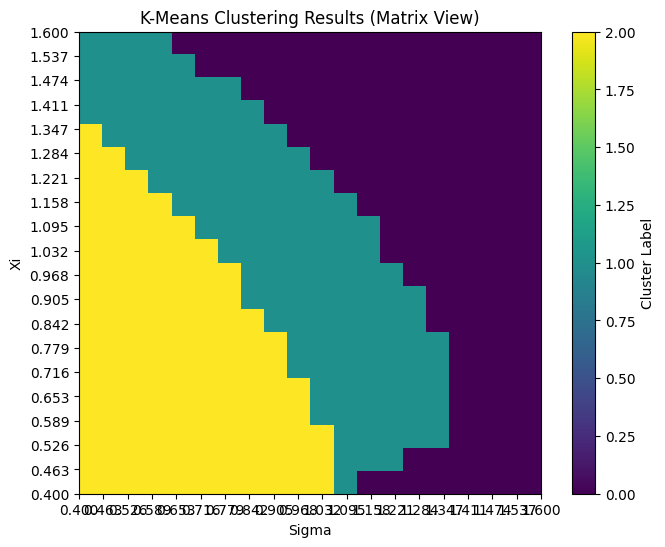

In [30]:
labels_matrix = labels.reshape(len(sigma_list), len(xi_list))

plt.figure(figsize=(8, 6))
plt.imshow(labels_matrix, cmap='viridis', origin='lower', extent=[sigma_list.min(), sigma_list.max(), xi_list.min(), xi_list.max()])
plt.colorbar(label="Cluster Label")
plt.xlabel("Sigma")
plt.ylabel("Xi")
plt.title("K-Means Clustering Results (Matrix View)")
plt.xticks(sigma_list)  # Label x-axis with sigma values
plt.yticks(xi_list)     # Label y-axis with xi values
plt.grid(visible=False) # Hide grid lines for a clean look
plt.show()

In [31]:
# sigma_mesh, xi_mesh = np.meshgrid(sigma_list, xi_list)
# labels_2D = labels.reshape(len(sigma_list), len(xi_list))  # Reshape to match grid

# plt.figure(figsize=(8, 6))
# plt.contourf(sigma_mesh, xi_mesh, labels_2D, cmap='viridis', alpha=0.6)
# plt.colorbar(label="Cluster Label")
# plt.xlabel("Sigma")
# plt.ylabel("Xi")
# plt.title("K-Means Clustering of Correlations")
# plt.show()

In [32]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# dimred = TSNE(n_components=2, perplexity=60, random_state=42)
dimred = PCA(n_components=2)
# correlations_reduced = dimred.fit_transform(correlations_list)

# plt.figure(figsize=(8, 6))
# plt.scatter(correlations_reduced[:, 0], correlations_reduced[:, 1], c=labels, cmap='viridis', edgecolors='k')
# plt.colorbar(label="Cluster Label")
# plt.xlabel("t-SNE Component 1")
# plt.ylabel("t-SNE Component 2")
# plt.title("t-SNE Visualization of Correlations")
# plt.show()

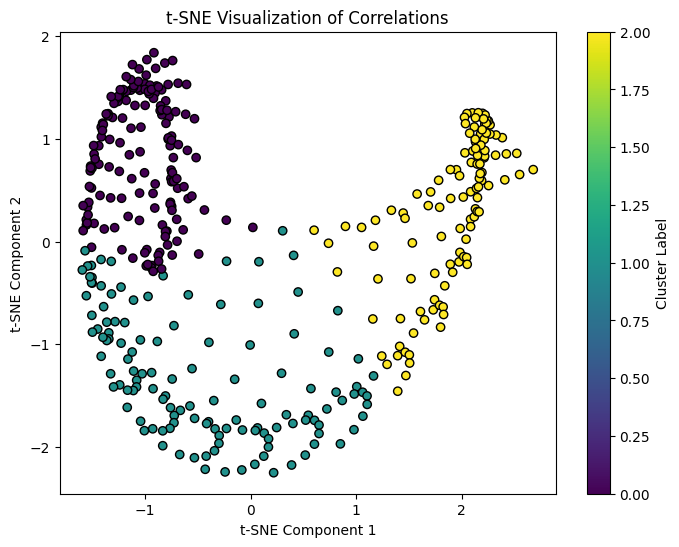

In [33]:
correlations_reduced = dimred.fit_transform(correlations_list)
plt.figure(figsize=(8, 6))
plt.scatter(correlations_reduced[:, 0], correlations_reduced[:, 1], c=labels, cmap='viridis', edgecolors='k')
plt.colorbar(label="Cluster Label")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of Correlations")
plt.show()

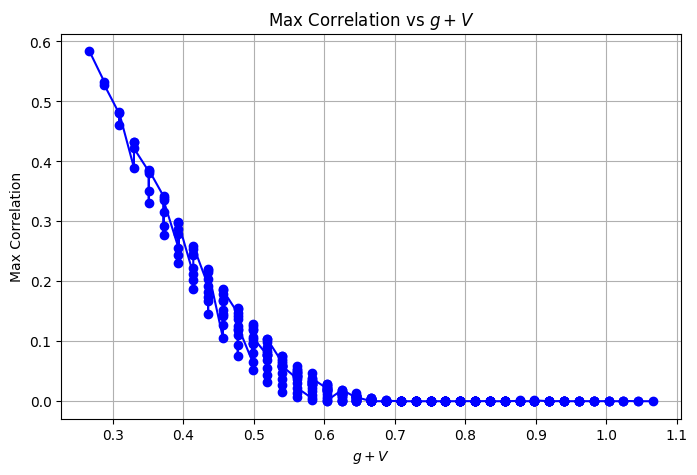

In [34]:
import numpy as np
import matplotlib.pyplot as plt

corr_max = np.min(correlations_list, axis=1)
g_mesh, V_mesh = np.meshgrid(g_list, V_list)

# Compute g + V for each pair
gV_values = g_mesh.flatten() + V_mesh.flatten()
corr_max_values = corr_max.flatten()

# Sort by g+V values
sorted_indices = np.argsort(gV_values)
gV_sorted = gV_values[sorted_indices]
corr_sorted = corr_max_values[sorted_indices]

# Plot the result
plt.figure(figsize=(8, 5))
plt.plot(gV_sorted, corr_sorted, marker='o', linestyle='-', color='b')
plt.xlabel(r'$g + V$')
plt.ylabel('Max Correlation')
plt.title('Max Correlation vs $g + V$')
plt.grid(True)
plt.show()

In [35]:
# get correlations from parameter lists
def get_max_correlations_from_param_list(times, g_list, V_list):
    n_tot = len(g_list) * len(V_list)
    correlations_list = np.empty((len(g_list), len(V_list)))
    i=0
    k=0
    l=0
    max_correlations_list = np.empty((len(g_list), len(V_list)))
    for i in range(len(g_list)):  
        for k in range(len(V_list)):
            H = get_ham_matrix_form(j, eps, g_list[i], V_list[k])
            correlations=0
            correlations = get_correlations_from_ham(H, times)
            
            # do fourier transform of correlations if wanted (uncomment otherwise)
            # correlations = np.fft.fft(correlations)
            # correlations = np.abs(correlations)
            max_correlations_list[i][k]=np.max(correlations)
            l=l+1
            if l % 1 == 0:
                    print(f"Progress: {l}/{n_tot}")
                # print(j, eps, g, V, len(correlations))
          
    return max_correlations_list
    

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

max_correlations_list_full = []
# for i in range(0,5):
#     print("#"*100)
#     print("Iteration: ", i)
#     random_state = np.random.rand(dim) + 1j * np.random.rand(dim)
#     initial_state = random_state / np.linalg.norm(random_state)
#     max_correlations_list_=get_max_correlations_from_param_list(times, g_list, V_list)

#     max_correlations_list_full.append(max_correlations_list_)

max_correlations_list_full = get_max_correlations_from_param_list(times, g_list, V_list)

/var/folders/z4/q3_z78fj4gldz7hpcmkdj1y00000gn/T/ipykernel_8880/1570019295.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  max_correlations_list[i][k]=np.max(correlations)


Progress: 1/400
Progress: 2/400
Progress: 3/400
Progress: 4/400
Progress: 5/400
Progress: 6/400
Progress: 7/400
Progress: 8/400
Progress: 9/400
Progress: 10/400
Progress: 11/400
Progress: 12/400
Progress: 13/400
Progress: 14/400
Progress: 15/400
Progress: 16/400
Progress: 17/400
Progress: 18/400
Progress: 19/400
Progress: 20/400
Progress: 21/400
Progress: 22/400
Progress: 23/400
Progress: 24/400
Progress: 25/400
Progress: 26/400
Progress: 27/400
Progress: 28/400
Progress: 29/400
Progress: 30/400
Progress: 31/400
Progress: 32/400
Progress: 33/400
Progress: 34/400
Progress: 35/400
Progress: 36/400
Progress: 37/400
Progress: 38/400
Progress: 39/400
Progress: 40/400
Progress: 41/400
Progress: 42/400
Progress: 43/400
Progress: 44/400
Progress: 45/400
Progress: 46/400
Progress: 47/400
Progress: 48/400
Progress: 49/400
Progress: 50/400
Progress: 51/400
Progress: 52/400
Progress: 53/400
Progress: 54/400
Progress: 55/400
Progress: 56/400
Progress: 57/400
Progress: 58/400
Progress: 59/400
Progre

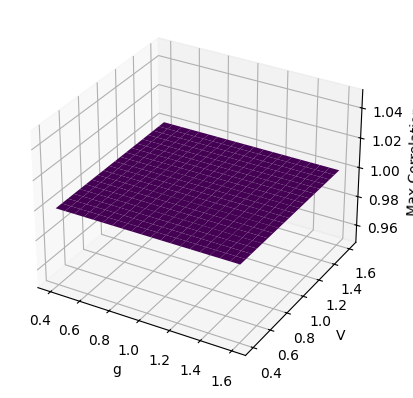

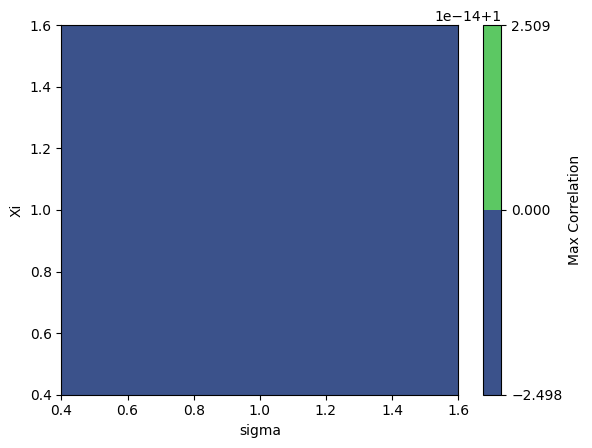

In [37]:


max_correlations_list = np.array(max_correlations_list_full)
#max_correlations_list = np.mean(max_correlations_list, axis=0)


# Create a meshgrid for g and V
Sigma, Xi = np.meshgrid(sigma_list, xi_list)

# Create the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(Sigma, Xi, max_correlations_list.T, cmap='viridis')

# Add labels
ax.set_xlabel('g')
ax.set_ylabel('V')
ax.set_zlabel('Max Correlation')

# Show the plot
plt.show()

# Create a meshgrid for g and V
Sigma, Xi = np.meshgrid(sigma_list, xi_list)

# Create the 2D color plot
plt.figure()
plt.contourf(Sigma, Xi, max_correlations_list.T, cmap='viridis')
plt.colorbar(label='Max Correlation')

# Add labels
plt.xlabel('sigma')
plt.ylabel('Xi')

# Show the plot
plt.show()

In [38]:
# # Create a grid of (sigma, xi) pairs
# sigma_values, xi_values = np.meshgrid(sigma_list, xi_list)
# sigma_flat = sigma_values.flatten()  # Convert to 1D array
# xi_flat = xi_values.flatten()        # Convert to 1D array

# # Plot scatter points with cluster labels as colors
# plt.figure(figsize=(8, 6))
# plt.scatter(sigma_flat, xi_flat, c=labels, cmap='viridis', edgecolors='k', s=100.)
# plt.colorbar(label="Cluster Label")
# plt.xlabel("Sigma")
# plt.ylabel("Xi")
# plt.title("K-Means Clustering of Correlations")
# plt.show()

In [39]:
# corr_times = np.linspace(0, t_max, 10)

# def get_ham_matrix_form(j, eps, g, V):
#     H_sec = agassi_hamiltonian(j, eps, g, V)
#     H_ps = qml.jordan_wigner(H_sec, ps=True, wire_map={0: 0, 1: 1, 2: 2, 3: 3})
#     order = list(range(n_qubits))
#     for i in range(0,n_qubits):
#         order[i]=i
#     H = qml.matrix(H_ps, wire_order=order)
#     return H

# H = get_ham_matrix_form(j, eps, g, V)

# ab = get_correlations_from_ham(H, corr_times, evo_func=exact_evo_new)
# print(len(ab))

In [40]:
# def get_correlations_from_params